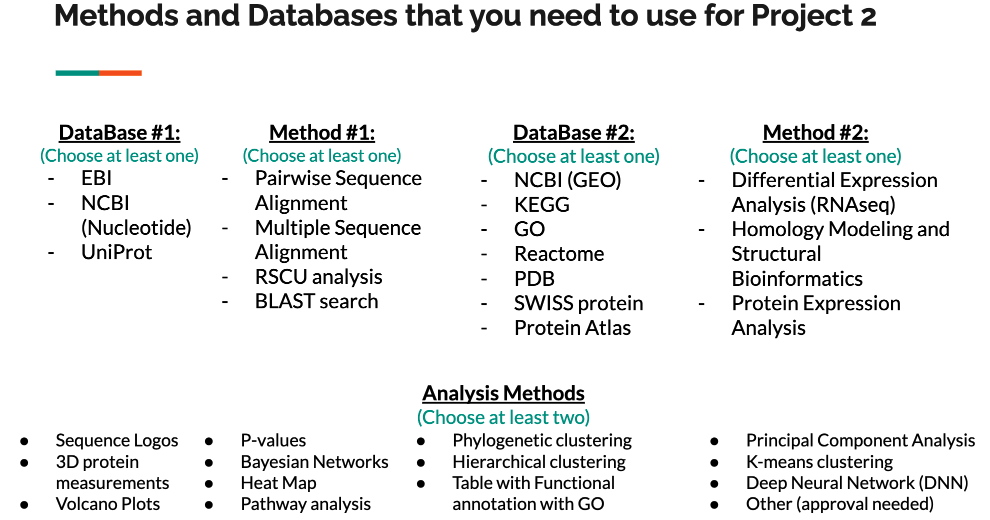

### Introduction (20 points)

- 5 points for specific, measurable, and clear scientific question

- 5 points for background on the protein/gene/species of interest and where the data is sourced from

- 5 points for clear, specific, and measurable scientific hypothesis that is in the form of an if-then statement

- 5 points for description of what analyses were done and how the data was downloaded for the project


# Introduction

## Scientific Question: Does the reduction of protein tyrosine phosphatase receptor type S (PTPRS) expression contribute to breast cancer tumorigenesis? If yes, is EGFR mediated EMT (epithelial-mesenchymal transition) pathway involved, or what other pathways are involved? 

### background: 
Protein tyrosine phosphatase receptor type S (PTPRS) is

RNAseq data were obatained from EBI database.

GO database


## Scientific Hypothesis: If PTPRS is shown as a metastatic suppressor in hepatocellular carcinoma, then it may also exhibit a similar regulatory role in breast ductal carcinoma and the loss of PTPRS may also contribute to the breast cancer metastasis by regulating similar mediators like EGFR.
Differential expression analysis 

Pathway analysis 

how the data was downloaded

# Loading in Packages

### Loading in Packages (15 points)

- 10 points for definition of each of the packages loaded 

- 5 points for correctly loading all of the packages needed and stating anything that needs to be done to load the packages (downloading the packages)


gseapy: https://gseapy.readthedocs.io/en/latest/introduction.html

In [1]:
# imports
import pandas as pd
import collections
import numpy as np
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.pyplot as plt
from bioinfokit import analys, visuz #for volcano plot

In [2]:
#install gseapy for pathway analysis #delete this line to install gseapy
pip install gseapy

Note: you may need to restart the kernel to use updated packages.


In [3]:
#for pathway analysis
%matplotlib inline
%config InlineBackend.figure_format='retina' 
%load_ext autoreload
%autoreload 2
import csv
import numpy as np
import pandas as pd
import gseapy as gp
import matplotlib.pyplot as plt
from gseapy.plot import barplot

### Performing Bioinformatics Analysis (20 points)

- 5 points for a description each of the bioinformatics method that includes data types read in and how the method works. 

- 5 points for code working correctly

- 5 points for adequate commenting in the code and code checks 

- 5 points for a function written that performs some part of the bioinformatics analyses

### Plotting The Results (15 points)

- 5 points for description of data analysis method

- 5 points for the code working for data analysis method

- 5 points for adequate commenting in the code for the data analysis method



# Method #1: Differential Expression Analysis (RNAseq)
## Database #1: EBI

In [91]:
#define a global variable rna_raw
rna_raw=pd.read_csv('30_breast_cancer_rna_TPM.csv') #load original csv file containing gene counts as variable rna_raw
#rna_raw.head() #uncomment to check original dataframe
rna_raw = rna_raw.fillna(0) #replace NaN values with 0
#define a global variable rna_adjust
rna_adjust =rna_raw.drop(columns = "Gene_ID").set_index("Gene_Name") #drop the column"Gene_ID" and set "Gene_Name" as index
#rna_adjust.head() #uncomment to check adjusted dataframe

In [92]:
#define a global variable rna_metadata
rna_metadata= pd.read_csv('30_breast_cancer_rna_experiment_design.csv') #load csv file containing experiment information
#rna_metadata.head() #uncomment to check dataframe
rna_metadata= rna_metadata.set_index("Sample Characteristic[cell line]") #set cell line name as index
#rna_metadata.head() #uncomment to check dataframe

disease= rna_metadata["Sample Characteristic[disease]"] #select the disease type column and define as a global variable disease
disease_type= pd.DataFrame(disease) # define a global variable disease_type 
disease_type= disease_type.rename(columns= {"Sample Characteristic[disease]" : "disease_type"})#rename column name
disease_type= disease_type.replace(regex=[' '], value='_') #replace space with underscore
#disease_type.head() #uncomment to check dataframe

In [93]:
#define a global variable unique_type 
unique_type = disease_type['disease_type'].unique()
#print(unique_type) #uncomment to check an array of unique disease types 

#for loop turning cell lines of each disease type into separate list
for i in unique_type:
    string = i
    globals()[string] = list(disease_type.loc[disease_type['disease_type'] == string].index) #define global variables name as each disease type in unique_type
    print (globals()[string]) #each list is stored in a variable named as the corresponding disease type, can be recalled with the variable 

#print(breast_adenocarcinoma) #uncomment to check correct for loop output

['BT20', 'BT474', 'BT549', 'HCC1187', 'HCC1395', 'HCC1419', 'HCC1500', '-MCF\xa07.00', 'MDAMB436', 'ZR7530']
['CAL120', 'CAMA1', 'MDAMB231', 'MDAMB361', 'MDAMB453', 'MDAMB468', 'SKBR3']
['CAL148', 'CAL51', 'HS578T', 'MFM-223', 'MDAMB157', 'SKBR7']
['HCC1569']
['HCC1806']
['HCC1937', 'HCC1954', 'HCC38', 'HCC70', 'T47D']


In [94]:
# Return a column to the pandas dataframe that has the sum of the reads for each gene under each of the disease type
rna_adjust['Sum_invasive_ductal_carcinoma'] = rna_adjust[invasive_ductal_carcinoma].sum(axis=1)
rna_adjust['Sum_breast_ductal_adenocarcinoma'] = rna_adjust[breast_ductal_adenocarcinoma].sum(axis=1)
# Calculate the mean for later when you calculate the p-value
rna_adjust['Mean_invasive_ductal_carcinoma'] = rna_adjust[invasive_ductal_carcinoma].mean(axis=1)
rna_adjust['Mean_breast_ductal_adenocarcinoma'] = rna_adjust[breast_ductal_adenocarcinoma].mean(axis=1)

# Calculate the standard deviation  for later when you calculate the p-value
rna_adjust['STD_invasive_ductal_carcinoma'] = rna_adjust[invasive_ductal_carcinoma].std(axis=1)
rna_adjust['STD_breast_ductal_adenocarcinoma'] = rna_adjust[breast_ductal_adenocarcinoma].std(axis=1)

#print(rna_adjust.head()) #uncommment to check new columns

In [95]:
# Calculate the Log Fold Change between the two conditions
Fold_change = rna_adjust['Sum_invasive_ductal_carcinoma']/rna_adjust['Sum_breast_ductal_adenocarcinoma']
rna_adjust['L2F'] = np.log2(Fold_change)
#print(rna_adjust.head())

/Users/rowenazhuang/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [96]:
rna_adjust.replace([np.inf, -np.inf], 0, inplace=True) #replace inf/-inf value in L2F column with 0 


In [97]:
# calculate p-values for each gene using a lambda function
# https://stackoverflow.com/questions/50137024/calculate-pvalue-from-pandas-dataframe
rna_adjust['pval'] = rna_adjust.apply(lambda x: stats.ttest_ind_from_stats(x['Mean_invasive_ductal_carcinoma'],x['STD_invasive_ductal_carcinoma'],x['Sum_invasive_ductal_carcinoma'], x['Mean_breast_ductal_adenocarcinoma'],x['STD_breast_ductal_adenocarcinoma'],x['Sum_breast_ductal_adenocarcinoma'])[1],axis=1)
#rna_adjust.head() #uncomment to check new column
rna_adjust = rna_adjust.fillna(0) #replace NaN value in pval column with 0

#calculate ajusted p-values
# https://campus.datacamp.com/courses/practicing-statistics-interview-questions-in-python/statistical-experiments-and-significance-testing?ex=13
#p-value vs. adjusted p-value: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6099145/
pd.set_option('display.float_format', lambda x: '%.20f' % x)
rna_adjust['padj'] = multipletests(rna_adjust['pval'], alpha=.05, method='bonferroni')[1]
#rna_adjust.head() #uncomment to check new column

/Users/rowenazhuang/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:5705: RuntimeWarning: divide by zero encountered in double_scalars
  denom = np.sqrt(svar * (1.0 / n1 + 1.0 / n2))
/Users/rowenazhuang/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:5705: RuntimeWarning: invalid value encountered in sqrt
  denom = np.sqrt(svar * (1.0 / n1 + 1.0 / n2))
/Users/rowenazhuang/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:5705: RuntimeWarning: invalid value encountered in double_scalars
  denom = np.sqrt(svar * (1.0 / n1 + 1.0 / n2))
/Users/rowenazhuang/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:5704: RuntimeWarning: invalid value encountered in double_scalars
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df
/Users/rowenazhuang/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:5704: RuntimeWarning: divide by zero encountered in double_scalars
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df


# Analysis method #1: Volcano plot

In [143]:
import math

In [144]:
rna_adjust['-log10padj'] = -np.log10(rna_adjust['padj'])



In [145]:
rna_adjust

,BT20,BT474,BT549,CAL120,CAL148,CAL51,CAMA1,HCC1187,HCC1395,HCC1419,...,Sum_invasive_ductal_carcinoma,Sum_breast_ductal_adenocarcinoma,Mean_invasive_ductal_carcinoma,Mean_breast_ductal_adenocarcinoma,STD_invasive_ductal_carcinoma,STD_breast_ductal_adenocarcinoma,L2F,pval,padj,-log10padj
Gene_Name,,,,,,,,,,,,,,,,,,,,,
TSPAN6,20.00000000000000000000,10.00000000000000000000,23.00000000000000000000,46.00000000000000000000,39.00000000000000000000,101.00000000000000000000,16.00000000000000000000,94.00000000000000000000,23.00000000000000000000,5.00000000000000000000,...,262.00000000000000000000,301.00000000000000000000,26.19999999999999928946,60.20000000000000284217,24.77364190694079582045,22.28676737438608412845,-0.20019667522225170764,0.00000000000000000000,0.00000000000000000000,47.92456987340982266232
TNMD,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.69999999999999995559,0.00000000000000000000,0.00000000000000000000,...,0.69999999999999995559,0.00000000000000000000,0.06999999999999999278,0.00000000000000000000,0.22135943621178658103,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,inf
DPM1,236.00000000000000000000,268.00000000000000000000,178.00000000000000000000,247.00000000000000000000,182.00000000000000000000,152.00000000000000000000,103.00000000000000000000,99.00000000000000000000,301.00000000000000000000,586.00000000000000000000,...,2456.00000000000000000000,977.00000000000000000000,245.59999999999999431566,195.40000000000000568434,136.95676527851975379235,54.19686337787454988302,1.32988009340179402784,0.00000000000000000000,0.00000000000000000000,22.87446680712788449341
SCYL3,15.00000000000000000000,32.00000000000000000000,7.00000000000000000000,5.00000000000000000000,26.00000000000000000000,10.00000000000000000000,20.00000000000000000000,11.00000000000000000000,8.00000000000000000000,19.00000000000000000000,...,155.00000000000000000000,70.00000000000000000000,15.50000000000000000000,14.00000000000000000000,7.56086414814250318273,3.31662479035539980998,1.14684138832927118301,0.11310236759640826532,1.00000000000000000000,-0.00000000000000000000
C1orf112,15.00000000000000000000,30.00000000000000000000,26.00000000000000000000,16.00000000000000000000,45.00000000000000000000,21.00000000000000000000,15.00000000000000000000,22.00000000000000000000,16.00000000000000000000,12.00000000000000000000,...,189.00000000000000000000,138.00000000000000000000,18.89999999999999857891,27.60000000000000142109,7.72370089759796218942,5.41294744108974335006,0.45371796744290371350,0.00000000000000000000,0.00000000000000000001,20.02775419430850689650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000285986,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.59999999999999997780,0.00000000000000000000,0.00000000000000000000,...,0.59999999999999997780,0.00000000000000000000,0.05999999999999999778,0.00000000000000000000,0.18973665961010274805,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,inf
ENSG00000285988,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,...,0.00000000000000000000,1.00000000000000000000,0.00000000000000000000,0.20000000000000001110,0.00000000000000000000,0.44721359549995798321,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,inf
ENSG00000285991,0.29999999999999998890,0.10000000000000000555,0.10000000000000000555,0.10000000000000000555,0.10000000000000000555,0.29999999999999998890,0.20000000000000001110,0.10000000000000000555,0.10000000000000000555,0.50000000000000000000,...,3.8999

In [152]:
#define a globle variable df containing L2F, pval, and padj columns
df = rna_adjust.iloc[:,-4:]
df = df.reset_index() #reset index to have Gene_Name column
#df #uncomment to check correct data frame

In [32]:
df[df['Gene_Name'] == 'PIK3CA']

,Gene_Name,L2F,pval,padj
5124,PIK3CA,0.53605290024020968431,0.00000000000000000000,0.00000000000000000000


PI3K: https://www.ebi.ac.uk/gxa/genes/ENSG00000121879?bs=%7B%22homo%20sapiens%22%3A%5B%22ORGANISM_PART%22%5D%7D&ds=%7B%22kingdom%22%3A%5B%22animals%22%5D%7D#information

In [35]:
#define a global variable interest as a tuple of genes of interests that involves in EGFR/PI3K pathway
interest = ('EGFR','KRAS','NRAS','RAF1','MAPK3','MAPK1','AKT1','AKT2','PTPRS', 'PIK3CA','MTOR','VEGFA')
#define a global varaible color as a tuple of colors
colors =("#E10600FF", "grey","#00239CFF")

In [174]:
df_i =df.set_index("Gene_Name")
df_i.replace([np.inf, -np.inf], 0, inplace=True)
up = df_i[(df_i['L2F'] > 1.5) & (df_i['padj'] < 0.05)]
sort_up = up.sort_values(by = 'L2F', ascending=False)
sort_up = sort_up.sort_values(by = '-log10padj', ascending=False)
DEGs_up_10 = sort_up.iloc[:10,:].index.tolist()
DEGs_up_10

['RPL3',
 'COPB1',
 'SLC25A6',
 'GRINA',
 'IPO7',
 'NDUFS5',
 'PRDX2',
 'SCD',
 'PHPT1',
 'XBP1']

In [175]:
up_10 = tuple (DEGs_up_10)

In [188]:
down = df_i[(df_i['L2F'] < -1.5) & (df_i['padj'] < 0.05)]
sort_down = down.sort_values(by = 'L2F', ascending=True)
sort_down = sort_down.sort_values(by = '-log10padj', ascending=False)
DEGs_down_10 = sort_down.iloc[:10,:].index.tolist()
DEGs_down_10

['CLDN1',
 'SLPI',
 'LCN2',
 'H1-2',
 'KLK6',
 'RARRES1',
 'ORMDL3',
 'EFEMP1',
 'KRT23',
 'DKK\xa01.00']

In [189]:
top_10 = tuple(DEGs_up_10 + DEGs_down_10)
top_10

('RPL3',
 'COPB1',
 'SLC25A6',
 'GRINA',
 'IPO7',
 'NDUFS5',
 'PRDX2',
 'SCD',
 'PHPT1',
 'XBP1',
 'CLDN1',
 'SLPI',
 'LCN2',
 'H1-2',
 'KLK6',
 'RARRES1',
 'ORMDL3',
 'EFEMP1',
 'KRT23',
 'DKK\xa01.00')

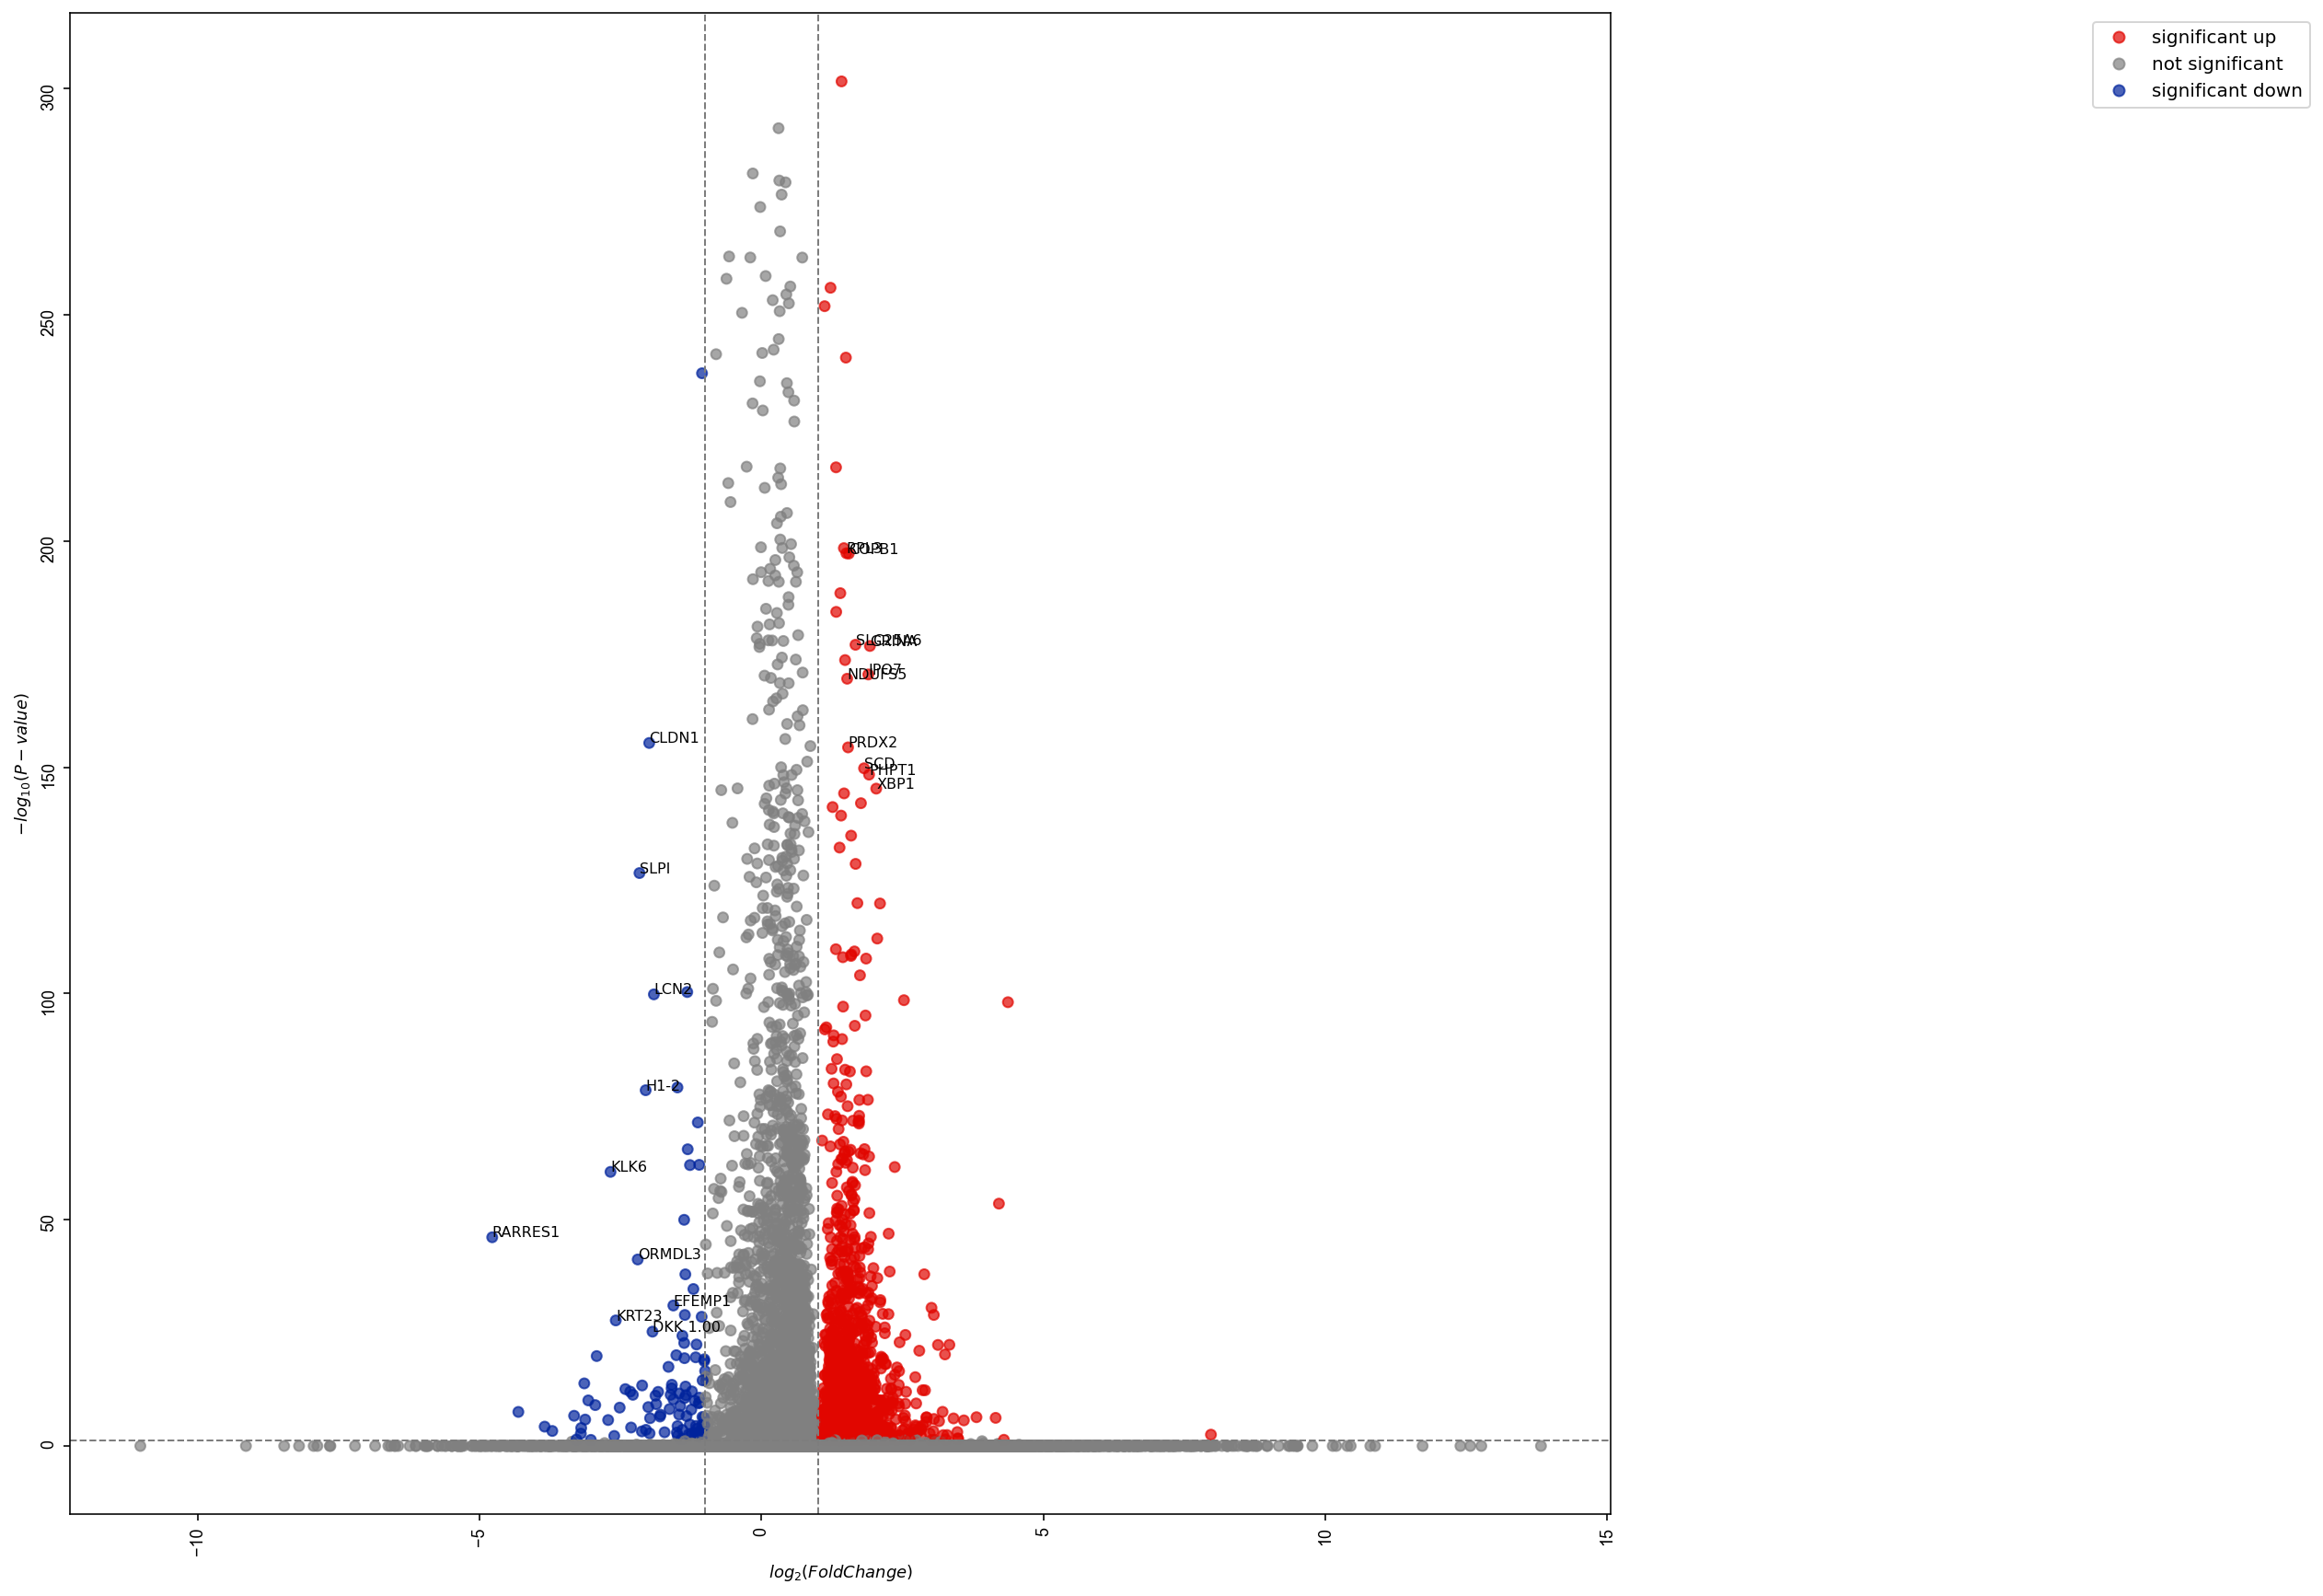

In [190]:
visuz.GeneExpression.volcano(df=df, lfc='L2F', pv='padj',
                             #xlm=(-6,6,1), 
                             color= colors,
                             valpha=0.7,
                             dotsize=30, 
                             geneid ='Gene_Name', 
                             genenames = top_10,
                             #gstyle=2,
                             sign_line=True,
                             plotlegend=True,legendpos='upper right', legendanchor=(1.46,1), 
                             dim = (15,15),
                             show=True)


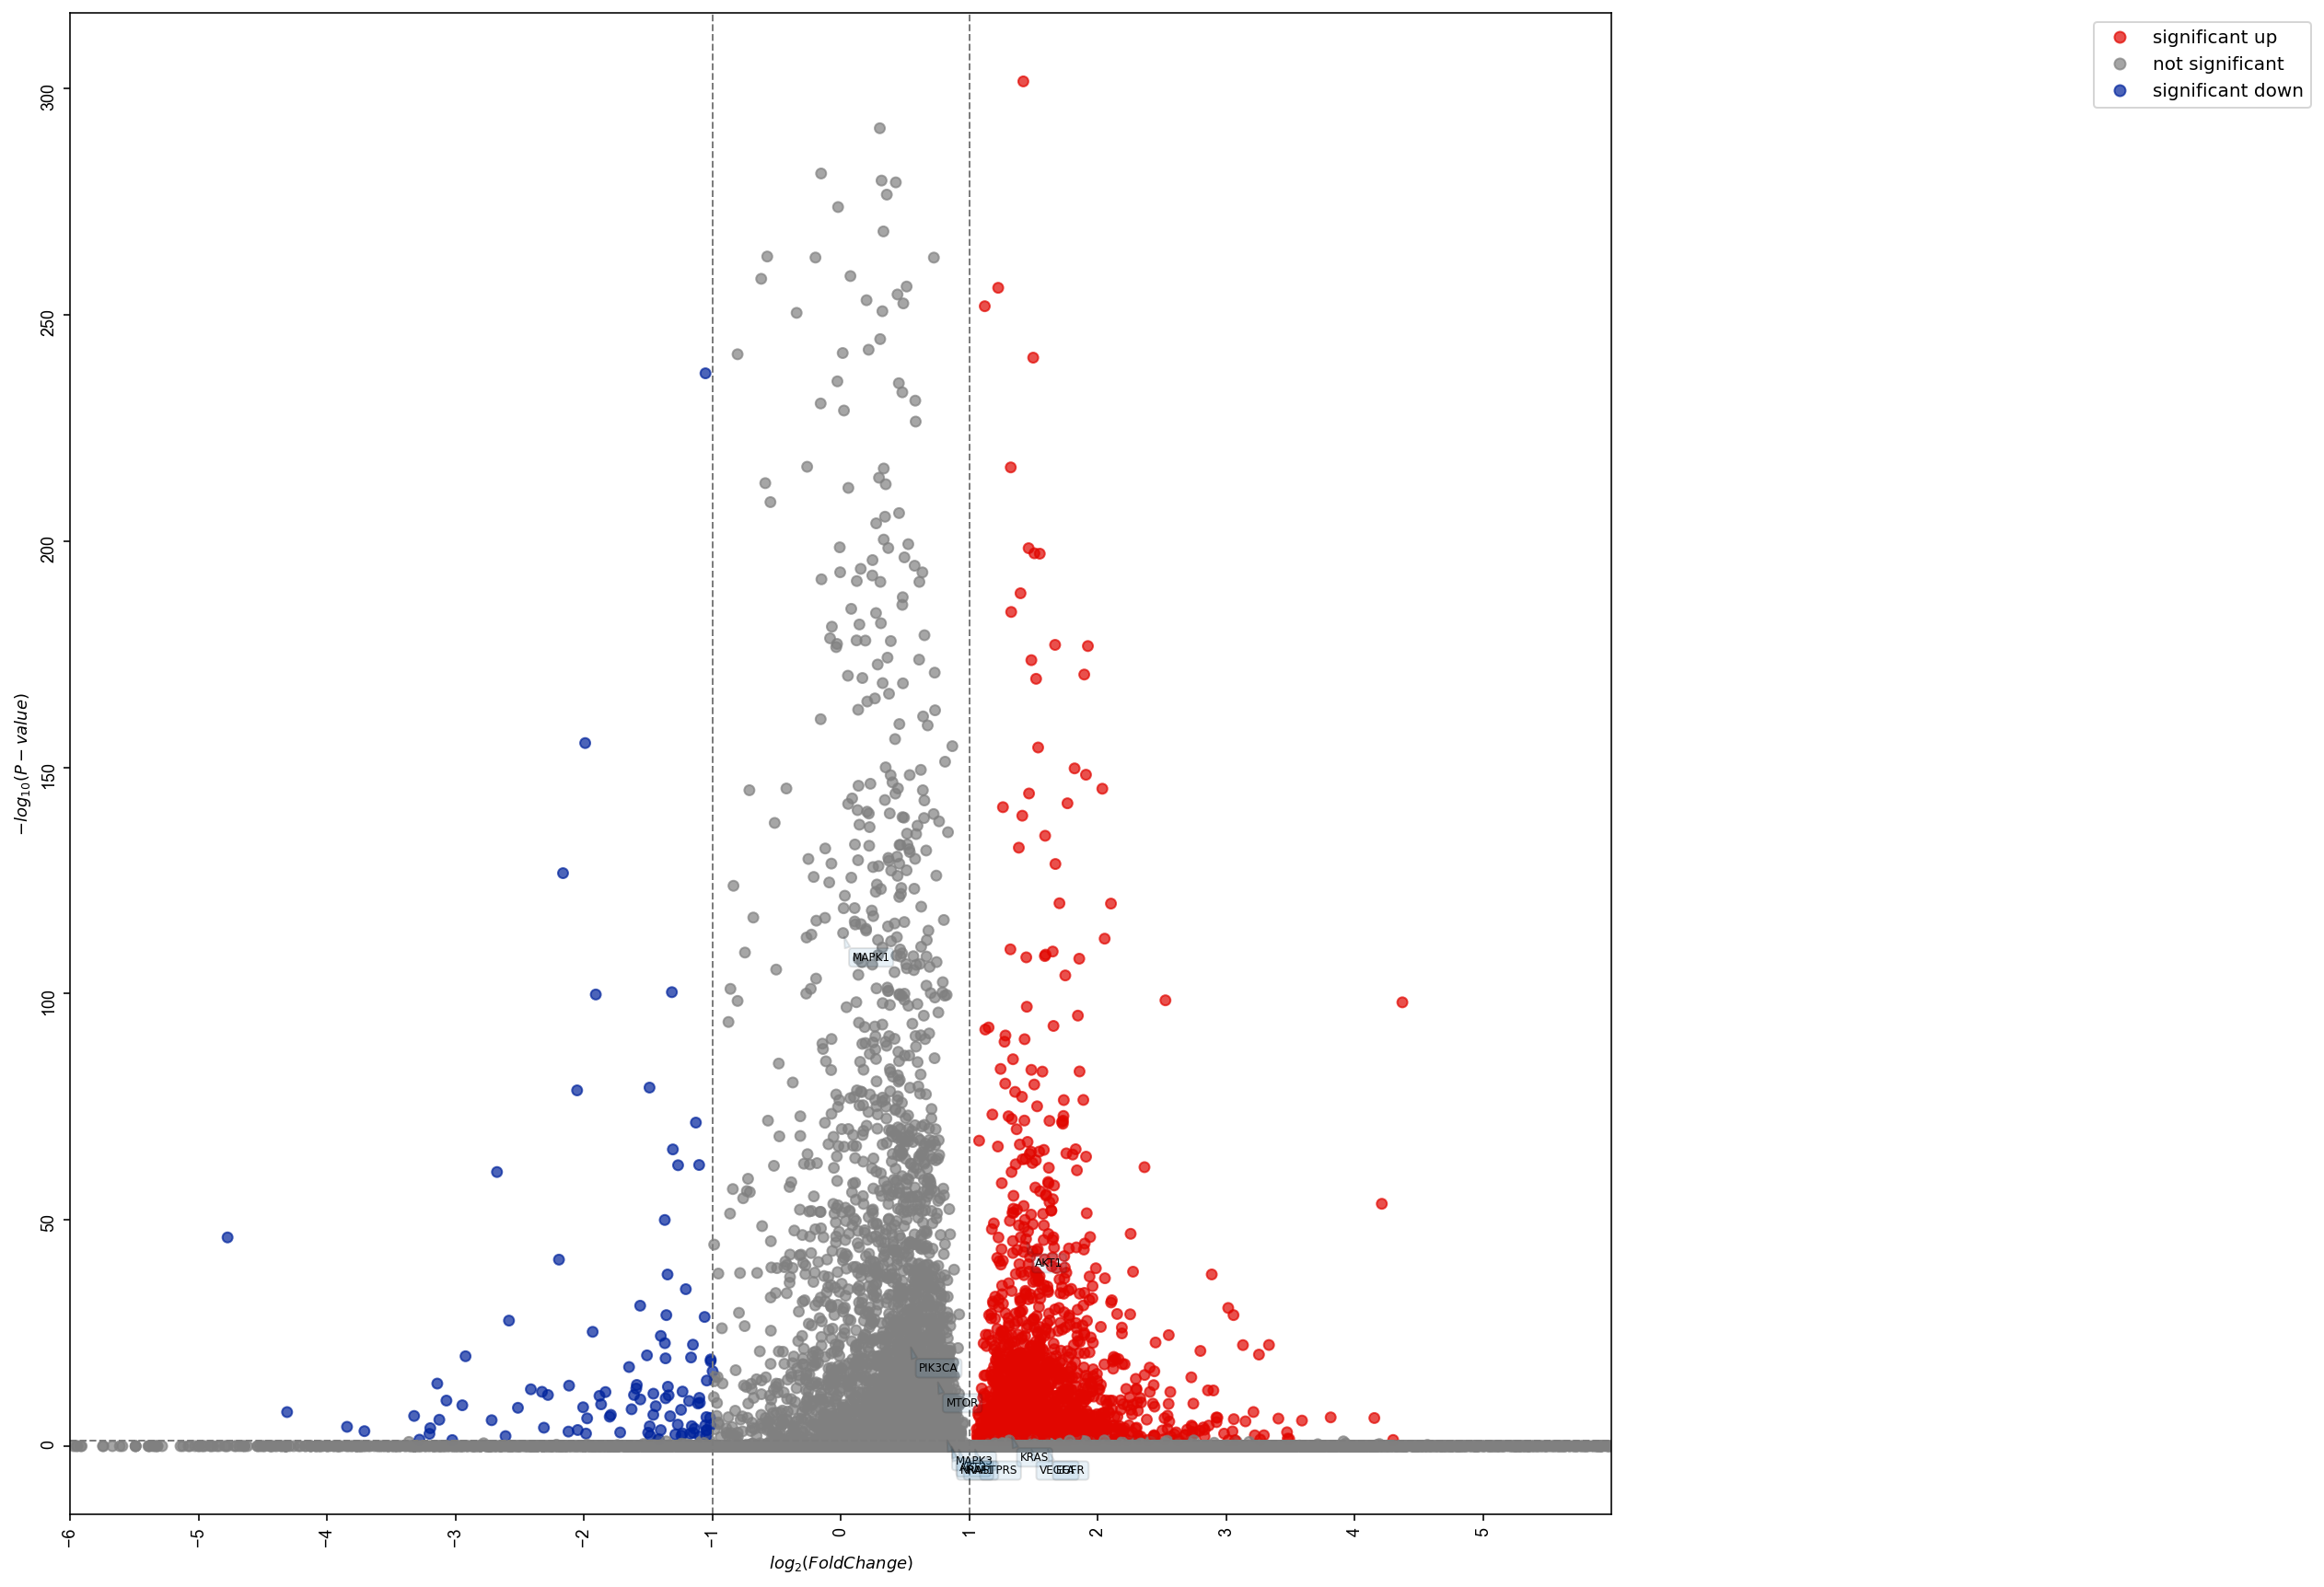

In [103]:
#https://www.reneshbedre.com/blog/volcano.html
#https://reneshbedre.github.io/blog/howtoinstall.html
visuz.GeneExpression.volcano(df=df, lfc='L2F', pv='padj',
                             xlm=(-6,6,1), 
                             color= colors,
                             valpha=0.7,
                             dotsize=30, 
                             geneid = 'Gene_Name', 
                             genenames = interest,
                             gstyle=2,
                             sign_line=True,
                             plotlegend=True,legendpos='upper right', legendanchor=(1.46,1), 
                             dim = (15,15),
                             show=True)


# Method #2: Pathway analysis
## Database #2: GO


In [38]:
names = gp.get_library_name()
#print(names) #uncomment to view available pathway datasets in gseapy

In [39]:
#filter for gene up and down regulated significantly with large fold change (DEGs: differentially expressed genes)
df =df.set_index("Gene_Name") #reset Gene_Name column as index, global variable
DEGs_up = (df[(df['L2F'] > 1.5) & (df['padj'] < 0.05)]).index.tolist() #define a global variable containing upregulated DEGs
DEGs_down = (df[(df['L2F'] < -1.5) & (df['padj'] < 0.05)]).index.tolist() #define a global variable containing downregulated DEGs
#Uncomment lines below to check which genes are up and down regulated
#print(DEGs_up_d)
#print(DEGs_down_d)

In [42]:
#define a global variable enr_GOBP_up query upregulated DEGs against GO Biological Processes (GOBP) dataset
enr_GOBP_up = gp.enrichr(gene_list=DEGs_up,
                         gene_sets=['GO_Biological_Process_2021'],
                         organism='Human', 
                         description='DEGs_up',
                         cutoff=0.5)
#define a global variable enr_GOMF_up query upregulated DEGs against GO Molecular Functions (GOMF) dataset
enr_GOMF_up = gp.enrichr(gene_list=DEGs_up ,
                         gene_sets=['GO_Molecular_Function_2021'],
                         organism='Human', 
                         description='DEGs_up',
                         cutoff=0.5)
#define a global variable enr_GOBP_up query downregulated DEGs against GO Biological Processes (GOBP) dataset
enr_GOBP_down = gp.enrichr(gene_list=DEGs_down,
                         gene_sets=['GO_Biological_Process_2021'],
                         organism='Human', 
                         description='DEGs_down',
                         cutoff=0.5)
#define a global variable enr_GOMF_up query downregulated DEGs against GO Molecular Functions (GOMF) dataset
enr_GOMF_down = gp.enrichr(gene_list=DEGs_down ,
                         gene_sets=['GO_Molecular_Function_2021'],
                         organism='Human', 
                         description='DEGs_down',
                         cutoff=0.5)

## Analysis method #2: Table with Functional annotation with GO

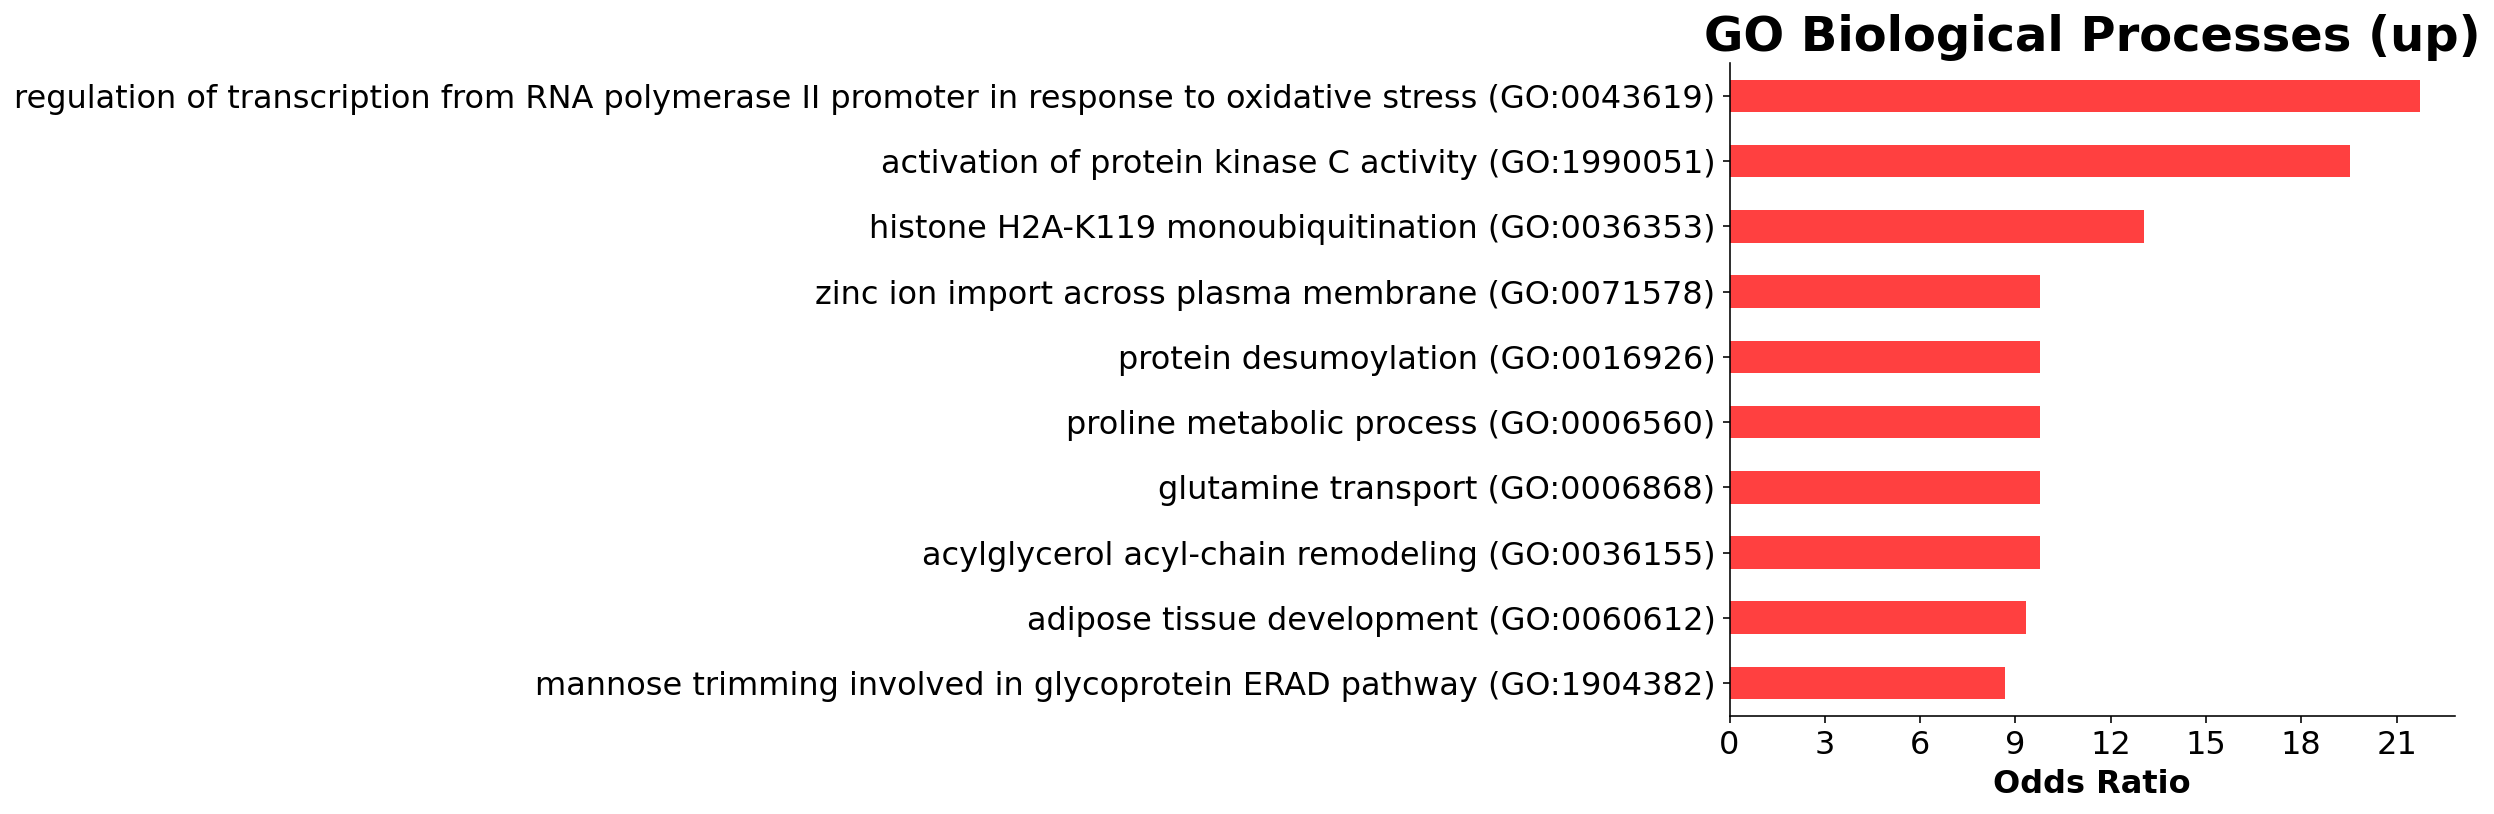

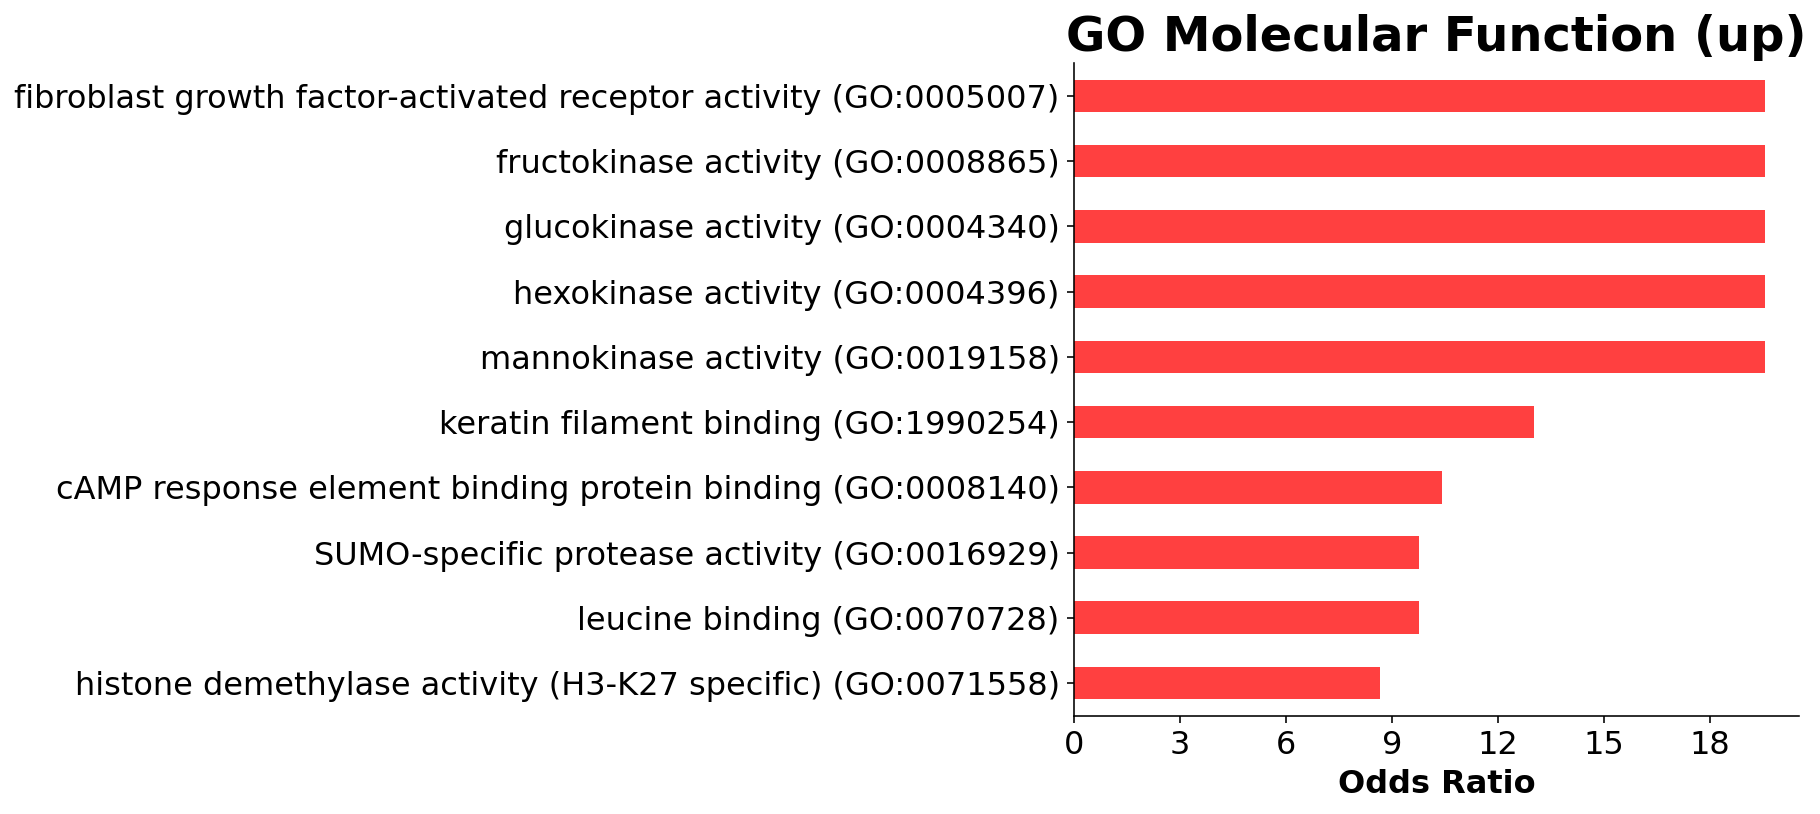

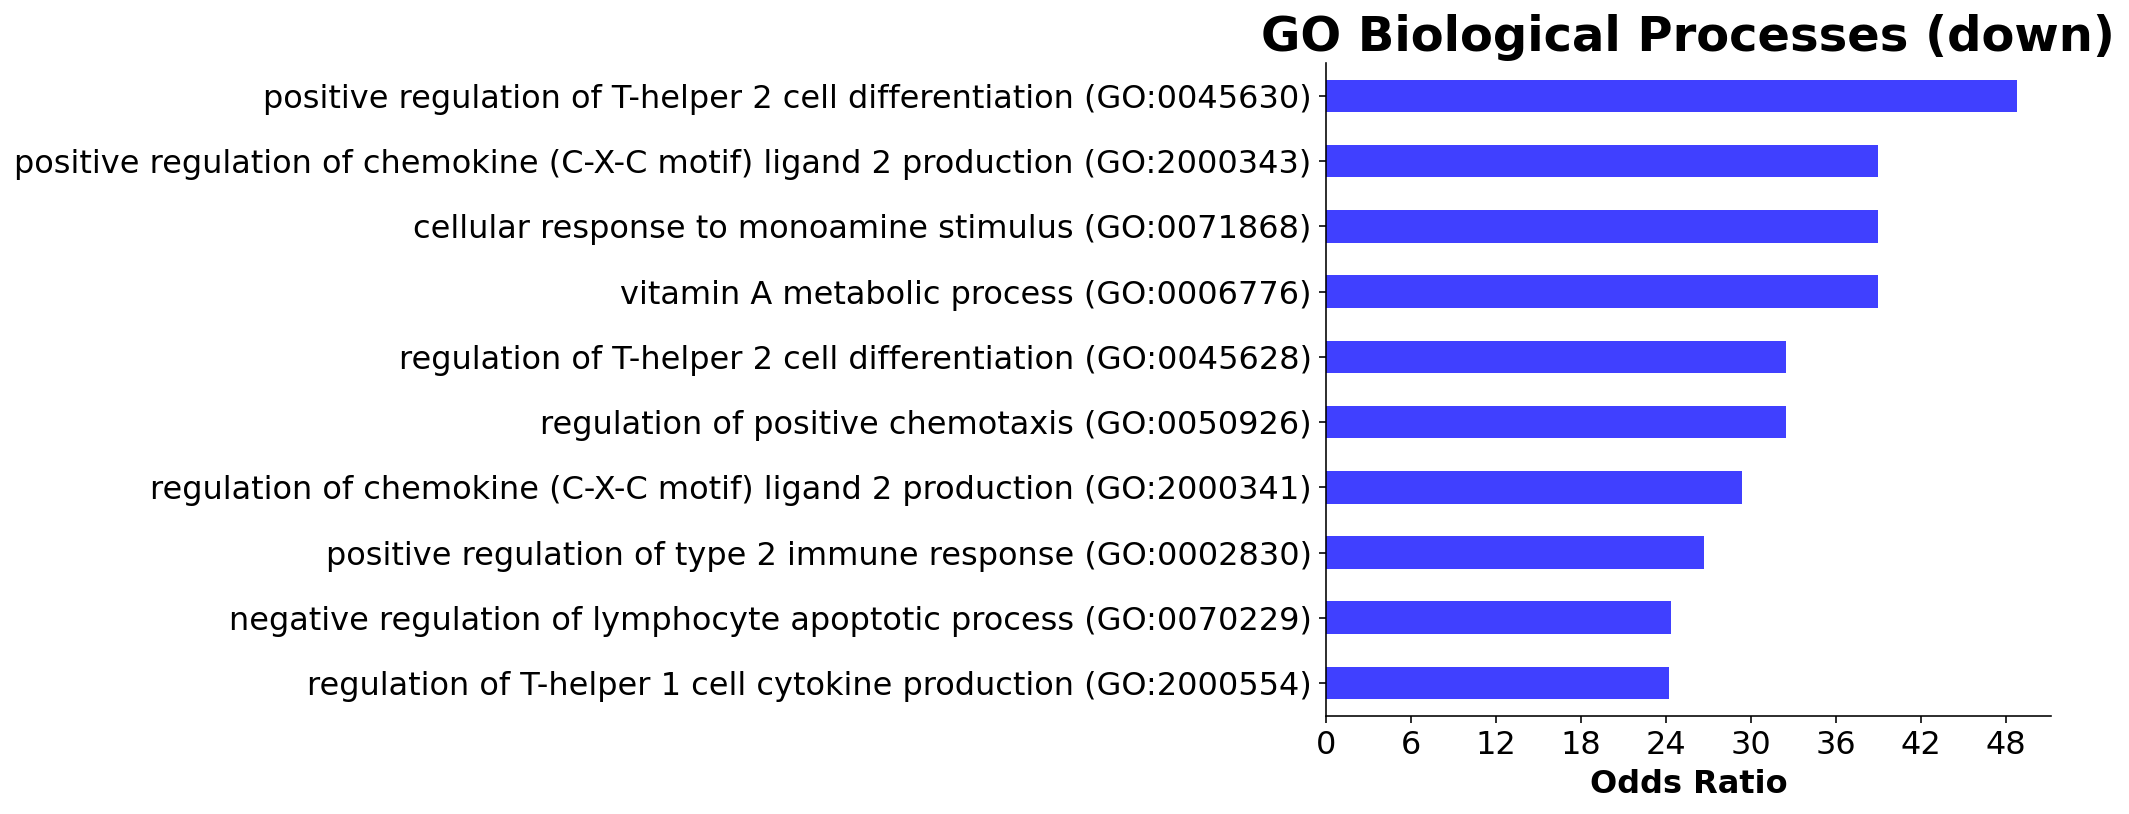

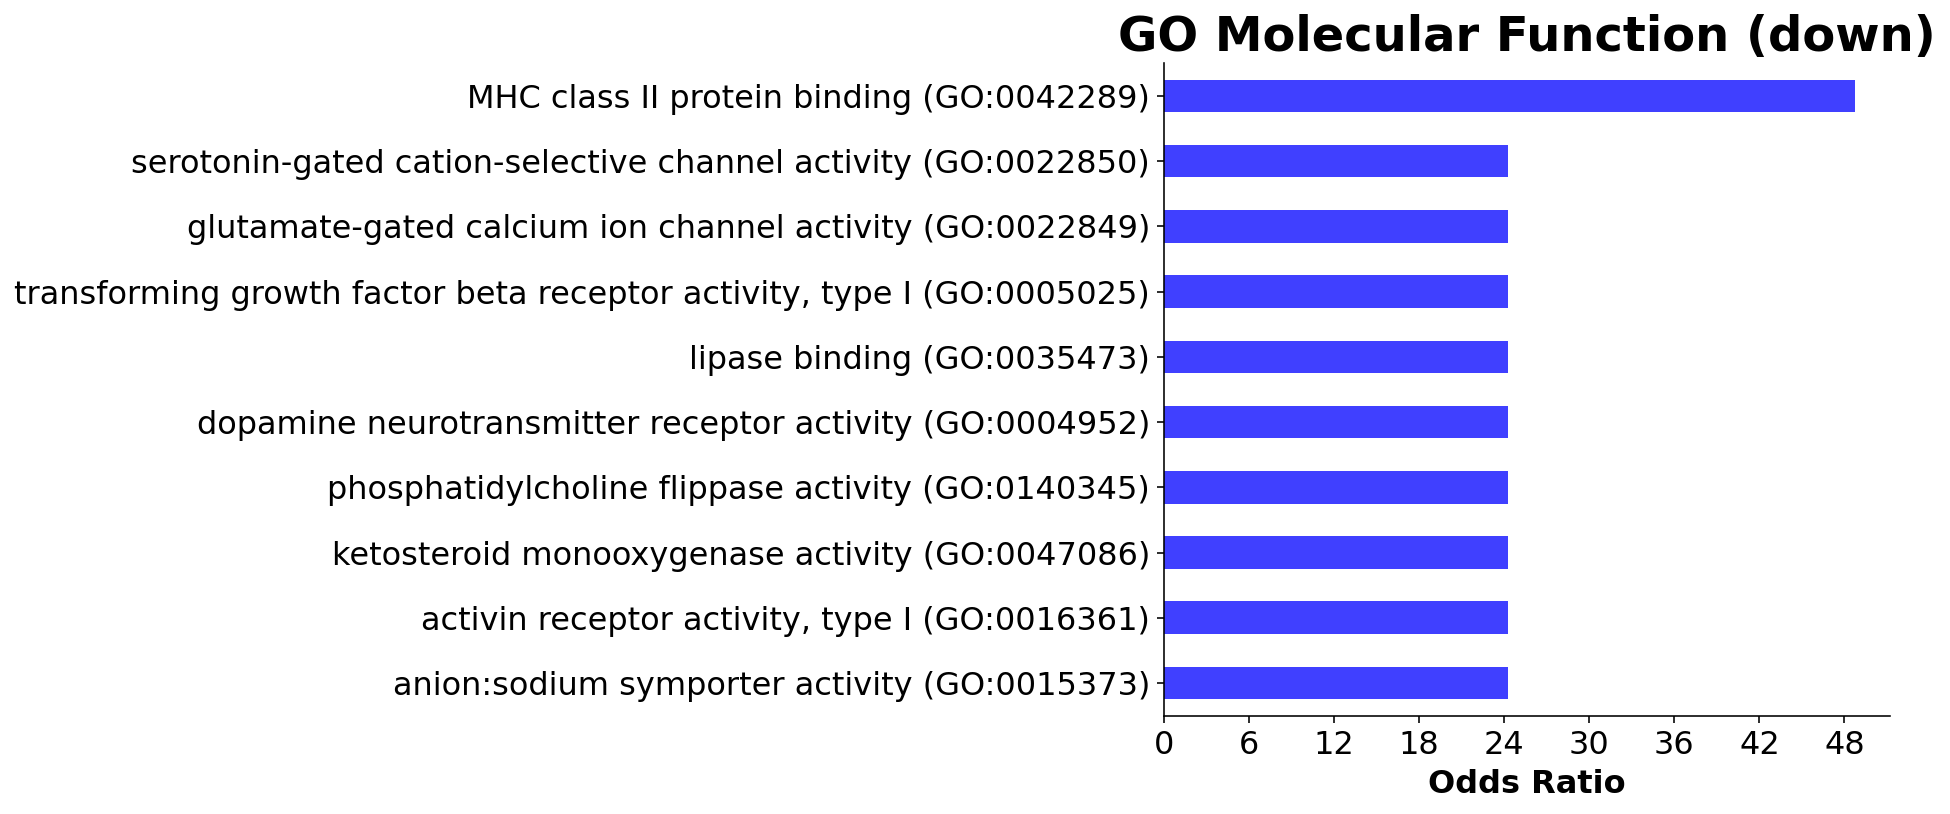

In [43]:
#visualize the top 10 enriched pathway in barplots
barplot(enr_GOBP_up.res2d, title='GO Biological Processes (up)', column = "Odds Ratio", color = 'r')

barplot(enr_GOMF_up.res2d, title='GO Molecular Function (up)', column = "Odds Ratio", color = 'r')

barplot(enr_GOBP_down.res2d,title='GO Biological Processes (down)', column = "Odds Ratio", color = 'b')

barplot(enr_GOMF_down.res2d,title='GO Molecular Function (down)', column = "Odds Ratio", color = 'b')


### Analyzing the Results (15 points)

- 15 points for correctly analyzing the data

### Code Formatting Requirements (15 points)

- 5 points for comments identifying global variables and local variables with in depth explanations of each

- 5 points for use of a built-in Bioconductor or Biopython function (or some other tool that was discussed in class like NumPy or SciPy), and description of what the function reads in and what it returns. 

- 5 points for hard-coding/redundant code being absent. 